In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.io.wavfile as sci_wav # Open wav files
import librosa
from scipy.signal import resample, butter, filtfilt
from sklearn.decomposition import PCA
import glob
from sklearn.ensemble import RandomForestClassifier 
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import MinMaxScaler, RobustScaler
from sklearn.svm import SVC
from mpl_toolkits.mplot3d import Axes3D

In [2]:
# 1 sec samples
road_wav_path = "d:\\DSUsers\\uic74928\\Komponente\\CNN\\audio_samples\\training_set\\road\\"
tunnel_wav_path = "d:\\DSUsers\\uic74928\\Komponente\\CNN\\audio_samples\\training_set\\tunnel\\"
# test files
test_road_wav_path = "d:\\DSUsers\\uic74928\\Komponente\\CNN\\audio_samples\\test_set\\road\\"
test_tunnel_wav_path = "d:\\DSUsers\\uic74928\\Komponente\\CNN\\audio_samples\\test_set\\tunnel\\"


### Define some constants

In [3]:
fs = 8000 # target freq
audio_sample_length = 1 # sec of signals
ts = 0.3 # seconds for FFT

n_mels = 40
Nfft = int(fs*ts)
window_step = int(Nfft/4)
n_mfcc = 15
power = 2
fix_length_s = audio_sample_length
fix_length = int(fix_length_s*fs)

### Functions

In [44]:
# The class_report function takes the true labels (y_true), predicted labels (y_pred), 
# and a dataset identifier (dataset) as input. It computes and prints the confusion matrix, 
# classification report, and accuracy score for the given predictions.
def class_report(y_true, y_pred, dataset): 
    confusion_mat = confusion_matrix(y_true, y_pred)
    classification_rep = classification_report(y_true, y_pred)
    accuracy = np.sum(np.array([y_true == y_pred])) / len(y_true)

    print(dataset + ' Set:\n')
    print(dataset + ' Confusion Matrix:')
    print(confusion_mat)
    print(dataset + ' Classification report:')
    print(classification_rep)
    print(dataset + ' Accuracy: ' + str(accuracy))
    print('\n')

    return confusion_mat, accuracy

# The padd_data function is used to fix the length of the input audio data. 
# If the input is a single audio sample, it applies the librosa.util.fix_length function to the sample. 
# If the input is a list of audio samples, it applies the librosa.util.fix_length function to each 
# sample and returns an array of fixed-length samples.
def padd_data(data_set, fix_length):
     if not isinstance(data_set, list):
        return librosa.util.fix_length(data_set, size = fix_length, axis=0, mode = 'wrap')
    
     else:
        data_set_fix_length = np.zeros((len(data_set),fix_length))
        for i,data in enumerate(data_set):
            data_set_fix_length[i,:] = librosa.util.fix_length(data, size = fix_length, axis=0, mode = 'wrap') 
        return data_set_fix_length

# The mfcc_extraction function is used to extract MFCC features from a fixed-length audio dataset. 
# It takes the fixed-length dataset, along with other parameters such as sampling rate (fs), FFT size (Nfft), 
# window step size (window_step), power, number of Mel bins (n_mels), and number of MFCC coefficients (n_mfcc).
# The function iterates over the fixed-length dataset and calculates the MFCC features for each sample using 
# the librosa.feature.mfcc function. It then flattens the MFCC matrix and stores the features in an array. 
# The resulting array contains the MFCC features for all samples in the dataset.
def mfcc_extraction(data_set_fix_length, fs, Nfft, window_step, power, n_mels, n_mfcc):
    flag = True
    for i, data in enumerate(data_set_fix_length):
        mfcc = librosa.feature.mfcc(y = data, sr=fs, n_fft=Nfft, hop_length = window_step,n_mfcc=n_mfcc, n_mels = n_mels, power = power)
        if(flag):
            mfcc_features = np.zeros((len(data_set_fix_length), mfcc.shape[0] * mfcc.shape[1]))
            flag = False
        mfcc_features[i,:] =  mfcc.ravel(order='F')  
    return mfcc_features

def mel_extraction(data_set_fix_length, fs, Nfft, window_step, n_mels):
    flag = True
    for i, data in enumerate(data_set_fix_length):
        mel = librosa.feature.melspectrogram(y=data, sr=fs, n_fft=Nfft, hop_length = window_step, power=2.0, n_mels = n_mels)
        if(flag):
            mel_features = np.zeros((len(data_set_fix_length), mel.shape[0] * mel.shape[1]))
            flag = False
        mel_features[i,:] =  mel.ravel(order='F')  
    return mel_features

# The preproces_raw_data function is used to preprocess raw audio data and extract features. 
# It takes the raw audio data as input and performs the following steps:
# 1. Calls the padd_data function to ensure that the data is of fixed length.
# 2. Sets the minimum and maximum frequency range for the mel spectrogram calculation.
# 3. If mfcc is set to True, it calculates the mel spectrogram using the librosa.feature.melspectrogram function, 
#    applies logarithmic compression using librosa.power_to_db, and then calls the mfcc_extraction function to extract MFCC 
#    features from the mel spectrogram.
# 4. If mfcc is set to False, it calls the mel_extraction function to extract features directly from the mel spectrogram.
# 5. Returns the extracted features.
def preproces_raw_data(data, mfcc=True):
    data_set_fix_length = padd_data(data, fix_length)
    f_min = 512
    f_max = 2000
    if mfcc:
        mel = librosa.feature.melspectrogram(y=data_set_fix_length, sr=fs, S=None, n_fft=Nfft, hop_length = window_step, power=2.0, n_mels = n_mels, fmin=f_min, fmax=f_max)
        mel_filtered = librosa.power_to_db(mel, ref=np.max)
        features = mfcc_extraction(mel_filtered, fs, Nfft, window_step, power, n_mels, n_mfcc)
    else:
        features = mel_extraction(data_set_fix_length, fs, Nfft, window_step, n_mels)
    return features

# The read_wav_files function reads WAV files and returns a list of the filtered audio data. 
# It takes a single WAV file or a list of WAV files as input and performs the following steps:
#   1. Checks if the input is a list of WAV files. If it's not a list, it converts it to a list with a single element.
#   2. Initializes an empty list to store the filtered audio data.
#   3. Iterates over each WAV file in the input list.
#   4. Reads the WAV file using sci_wav.read and extracts the audio data.
#   5. Calculates the mean value of the audio data.
#   6. Subtracts the mean value from the audio data to remove the DC offset.
#   7. Appends the filtered audio data to the wavl_list.
#   8. Returns the wavl_list containing the filtered audio data.
def read_wav_files(wav_files):
    if not isinstance(wav_files, list):
        wav_files = [wav_files]

    wavl_list = []
    for f in wav_files:
        data = sci_wav.read(f)[1]

        # Calculate the mean values
        mean_data = np.mean(data)
        # Remove the mean from signals
        filtered_wav = data - mean_data
        wavl_list.append(filtered_wav)

    return wavl_list

# The k_fold_cross_val function performs k-fold cross-validation for a given classifier (clf) 
# and a range of parameter values (param_values). It takes the following input parameters:
#   clf: The classifier object used for training and evaluation.
#   X: The input features or data matrix.
#   y: The target variable or labels.
#   scoring: The scoring metric used for evaluation (e.g., accuracy, precision, recall).
#   k: The number of folds for cross-validation.
#       param_values: The list of parameter values to be evaluated.
#  The function iterates over the parameter values and performs the following steps for each parameter value:
# 1. Initializes a PCA object with the specified number of components (param).
# 2. Transforms the input features X using PCA to obtain the transformed feature matrix X_train.
# 3. Performs k-fold cross-validation using the classifier clf, the transformed features X_train, and the target variable y.
# 4. Computes the mean and standard deviation of the scores obtained from cross-validation.
# 5. Appends the mean and standard deviation to the mean_acc_arr and std_acc_arr lists, respectively.
# 6. The function returns the lists mean_acc_arr and std_acc_arr, which contain the mean and standard deviation of the scores 
# for each parameter value.
def k_fold_cross_val(clf, X, y, scoring, k, param_values):
    mean_acc_arr = []
    std_acc_arr = []
    for param in param_values:
        
        pca = PCA(n_components=param)
        X_train = pca.fit(X).transform(X)

        scores = cross_val_score(clf, X_train, y, cv=k)
        mean_acc_arr.append(np.mean(scores))
        std_acc_arr.append(np.std(scores))
        
    return mean_acc_arr, std_acc_arr

def print_confusion_matrix(data_class, confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    plt.title(data_class)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


### Prepare dataset

In [6]:
wav_files_road = glob.glob(road_wav_path + "*.wav")
wav_files_tunnel = glob.glob(tunnel_wav_path + "*.wav")

data_roads = read_wav_files(wav_files_road)
data_tunnels = read_wav_files(wav_files_tunnel)


wav_files_road_test = glob.glob(test_road_wav_path + "*.wav")
wav_files_tunnel_test = glob.glob(test_tunnel_wav_path + "*.wav")

data_roads_test = read_wav_files(wav_files_road_test)
data_tunnel_test = read_wav_files(wav_files_tunnel_test)


### Prepare training and test data

In [7]:
X_train_ =  preproces_raw_data(data_roads + data_tunnels)
y_train = np.concatenate((np.zeros(len(data_roads)), np.ones(len(data_tunnels))))

X_test_ =  preproces_raw_data(data_roads_test + data_tunnel_test)
y_test = np.concatenate((np.zeros(len(data_roads_test)), np.ones(len(data_tunnel_test))))

C:\Users\uic74928\AppData\Local\Programs\Python\Python39\lib\site-packages\librosa\core\spectrum.py:256: UserWarning: n_fft=2400 is too large for input signal of length=14
  warnings.warn(


### K-fold Cross Validation for Logistic Regression

In this code snippet, k-fold cross-validation is performed to determine the optimal number of components for logistic regression. The logistic regression model is initialized with the `LogisticRegression` class from scikit-learn.

- The `clf` variable stores an instance of the logistic regression model, with a specified regularization parameter `C` and solver `lbfgs`.

- The `n_components_list` contains a list of potential values for the number of components.

- The `k_fold_cross_val` function is called to perform k-fold cross-validation. It takes the logistic regression model `clf`, the training data `X_train_`, the target labels `y_train`, the scoring metric (if any), the number of folds `k`, and the parameter values to be evaluated `param_values` (in this case, `n_components_list`). This function returns the mean and standard deviation of the accuracy scores obtained for each parameter value.

- The variable `mean_acc_arr` stores the mean accuracy scores obtained from k-fold cross-validation for each number of components.

- The variable `std_acc_arr` stores the corresponding standard deviation of the accuracy scores.

- The optimal number of components is determined as the value that yields the highest mean accuracy. The variable `n_components` is assigned the value from `n_components_list` at the index of the maximum mean accuracy.

- The best accuracy and the corresponding number of components are printed.

This process helps in identifying the optimal number of components to be used in the logistic regression model based on the performance obtained through k-fold cross-validation.


In [8]:
clf = LogisticRegression(C=1e5, solver='lbfgs')

n_components_list = [2, 5 ,10, 15, 20, 25, 50, 67, 80, 100, 200]

mean_acc_arr, std_acc_arr = k_fold_cross_val(clf, X_train_, y_train, scoring = None, k = 5, param_values = n_components_list)


n_components = n_components_list[np.argmax(mean_acc_arr)]

print("Best accuracy for k fold cross validation in: ", max(mean_acc_arr)," for: ", n_components_list[np.argmax(mean_acc_arr)]," components")


Best accuracy for k fold cross validation in:  0.9974999999999999  for:  5  components


### Logistic Regression with PCA

In this code snippet, logistic regression is performed with different numbers of principal components (PCA) using a loop. The purpose is to evaluate the performance of the logistic regression model with varying numbers of PCA components.

- The loop iterates over a list of specified values for `n_components`, which includes some specific values and the shape of `X_train_` (number of features).

- For each iteration, if the `n_components` value is less than or equal to the number of samples in `X_train_`, PCA is applied. Otherwise, no dimensionality reduction is performed, and `X_train` and `X_test` remain the same as `X_train_` and `X_test_`, respectively.

- A logistic regression model (`logreg`) is initialized with the specified parameters: `C` and `solver`.

- The logistic regression model is trained and fitted using the training data (`X_train`) and target labels (`y_train`), and then predictions are made for both the training and test data.

- The accuracy scores for both the training and test sets are calculated by comparing the predicted labels (`y_train_pred` and `y_test_pred`) with the actual labels (`y_train` and `y_test`).

- The accuracy scores for each iteration are printed, including the number of PCA components used and the corresponding training and test accuracies.

This loop allows for the evaluation of logistic regression performance with different numbers of PCA components. It provides insights into how the performance varies as the dimensionality of the data is reduced using PCA.


In [10]:
for n_components in [5, 10, 13, 15 , 17, 19, 25, 50, 67, 80, 100, 200, X_train_.shape[1]]:
    if(n_components <=  X_train_.shape[0]):
        pca = PCA(n_components=n_components)
        X_train = pca.fit(X_train_).transform(X_train_)
        X_test = pca.transform(X_test_)
    else:
        X_train = X_train_
        X_test = X_test_

    logreg = LogisticRegression(C=1e5, solver='lbfgs')

    y_train_pred = logreg.fit(X_train, y_train).predict(X_train)
    y_test_pred = logreg.predict(X_test)

    
    print("#############################")
    print("Accurasy for n PCA compoenets: ", n_components)
    print("Training " + ' accuracy: ' + str(np.sum(np.array([y_train==y_train_pred]))/len(y_train))) 
    print("Test " + ' accuracy: ' + str(np.sum(np.array([y_test==y_test_pred]))/len(y_test))) 
    print("")

#############################
Accurasy for n PCA compoenets:  5
Training  accuracy: 1.0
Test  accuracy: 0.99375

#############################
Accurasy for n PCA compoenets:  10
Training  accuracy: 1.0
Test  accuracy: 0.98125

#############################
Accurasy for n PCA compoenets:  13
Training  accuracy: 1.0
Test  accuracy: 0.975

#############################
Accurasy for n PCA compoenets:  15
Training  accuracy: 1.0
Test  accuracy: 0.96875

#############################
Accurasy for n PCA compoenets:  17
Training  accuracy: 1.0
Test  accuracy: 0.96875

#############################
Accurasy for n PCA compoenets:  19
Training  accuracy: 1.0
Test  accuracy: 0.975

#############################
Accurasy for n PCA compoenets:  25
Training  accuracy: 1.0
Test  accuracy: 0.9875

#############################
Accurasy for n PCA compoenets:  50
Training  accuracy: 1.0
Test  accuracy: 0.98125

#############################
Accurasy for n PCA compoenets:  67
Training  accuracy: 1.0
Test 

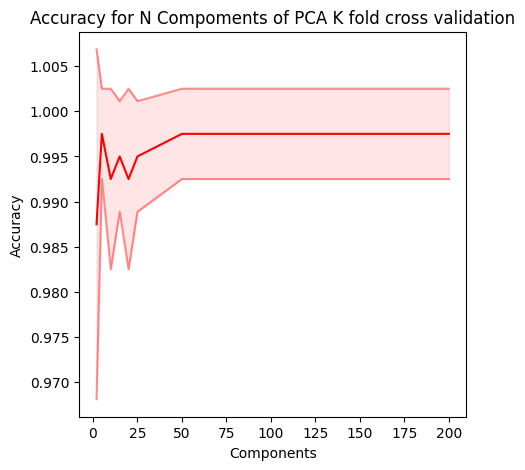

In [11]:
plt.figure(figsize=(5,5))

plt.title("Accuracy for N Compoments of PCA K fold cross validation")
plt.xlabel("Components")
plt.ylabel("Accuracy")
y1 = np.array(mean_acc_arr) -  np.array(std_acc_arr)
y2 = np.array(mean_acc_arr) +  np.array(std_acc_arr)
plt.plot(n_components_list, mean_acc_arr, 'r')
plt.plot(n_components_list, y1, 'r', alpha = 0.4)
plt.plot(n_components_list, y2, 'r', alpha = 0.4)
plt.fill_between(n_components_list, y1, y2, color = 'r', alpha = 0.1)

### PCA for Dimensionality Reduction and Data Scaling

In this code snippet, PCA is used for dimensionality reduction, and the data is also scaled using the RobustScaler before applying PCA.

- The variable `n_components` is set to the maximum value of 200, indicating that the maximum number of components will be used for PCA.

- The RobustScaler is initialized and stored in the `scaller` variable. This scaler is used to preprocess the data and handle potential outliers.

- The training and test data, `X_train_` and `X_test_`, respectively, are scaled using the `RobustScaler`'s `fit_transform` method. This step standardizes the features of the data, making them more suitable for PCA.

- PCA is then applied to the scaled data. The `PCA` class is initialized with the specified `n_components` value. PCA is first fit on the training data (`X_train_`) using the `fit` method and then applied to both the training and test data using the `transform` method.

- The transformed data is stored in the variables `X_train` and `X_test`, representing the reduced-dimension representations of the original data.

This process of scaling the data and applying PCA helps in reducing the dimensionality of the data while preserving the most important information. It also ensures that the data is standardized and ready for further analysis or modeling steps.


In [30]:
n_components = 200

# scale the data, pre-process add to research paper
scaller = RobustScaler()
X_train_ = scaller.fit_transform(X_train_)
X_test_ = scaller.fit_transform(X_test_)

pca = PCA(n_components=n_components)

X_train = pca.fit(X_train_).transform(X_train_)
X_test = pca.transform(X_test_)

### Visualizing PCA Results

In this code snippet, the results of PCA are visualized using scatter plots and a cumulative sum plot of the explained variance ratios.


Text(0.5, 1.0, 'Cummulative PCA component variance')

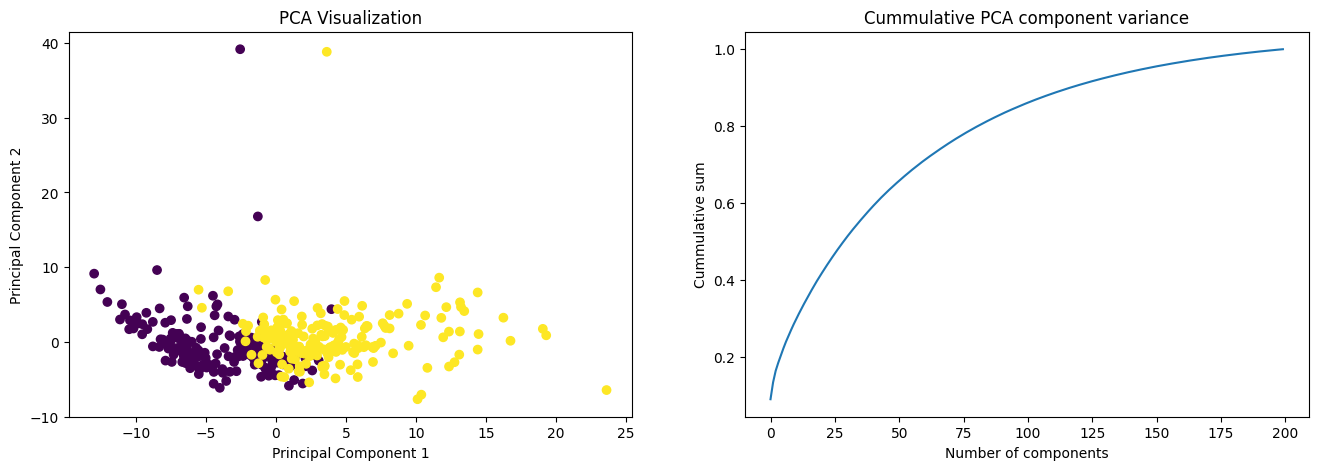

In [31]:
plt.figure(figsize=(16,5))

# Visualize the data in the reduced-dimensional space
plt.subplot(121)
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA Visualization')

# plot strenngth of components, varianse
var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(var_ratio)/np.sum(var_ratio)

plt.subplot(122)
plt.plot(cum_var_ratio)
plt.xlabel('Number of components')
plt.ylabel('Cummulative sum')
plt.title('Cummulative PCA component variance')

### Logistic Regression and Performance Evaluation

In this code snippet, logistic regression is applied to the reduced-dimensional data, and the performance of the model is evaluated using classification metrics.

- A logistic regression classifier is initialized with the specified parameters: `C=1e5` and `solver='lbfgs'`. This classifier is stored in the variable `logreg`.

- The logistic regression model is trained on the reduced-dimensional training data (`X_train`) and corresponding target labels (`y_train`). The `fit` method is used to fit the model to the data, and the `predict` method is then used to make predictions on the training data. The predicted labels are stored in the variable `y_train_pred`.

- The logistic regression model is also used to make predictions on the reduced-dimensional test data (`X_test`). The predicted labels are stored in the variable `y_test_pred`.

- The performance of the model on the test data is evaluated using the `class_report` function. This function takes the predicted labels (`y_test_pred`), true labels (`y_test`), and a dataset identifier ('Test') as inputs. It computes and returns the confusion matrix and accuracy of the predictions. These values are stored in the variables `confusion_mat` and `accuracy`, respectively.

The logistic regression model is trained on the reduced-dimensional data and used to make predictions on both the training and test data. The performance metrics provide an evaluation of how well the model generalizes to unseen data and can be used to assess its effectiveness in classifying the audio samples.


In [32]:
logreg = LogisticRegression(C=1e5, solver='lbfgs')
y_train_pred = logreg.fit(X_train, y_train).predict(X_train)
y_test_pred = logreg.predict(X_test)
confusion_mat, accuracy = class_report(y_test_pred, y_test, dataset='Test')

Test Set:

Test Confusion Matrix:
[[79  1]
 [ 1 79]]
Test Classification report:
              precision    recall  f1-score   support

         0.0       0.99      0.99      0.99        80
         1.0       0.99      0.99      0.99        80

    accuracy                           0.99       160
   macro avg       0.99      0.99      0.99       160
weighted avg       0.99      0.99      0.99       160

Test Accuracy: 0.9875




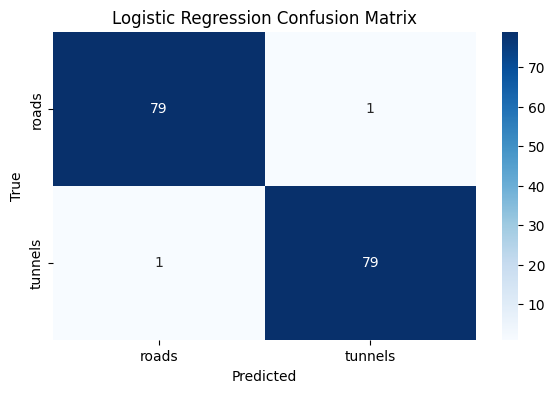

In [33]:
plt.figure(figsize=(15, 4))
plt.subplot(121)
labels = ['roads', 'tunnels']
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Logistic Regression' + ' Confusion Matrix')
plt.show()

### Support Vector Machine (SVM) and Performance Evaluation

In this code snippet, a Support Vector Machine (SVM) classifier is trained on the reduced-dimensional data using the `fit` method. The trained classifier is then used to make predictions on the test data using the `predict` method.

- An SVM classifier is initialized without specifying any parameters, resulting in the default settings. The classifier is stored in the variable `svc`.

- The SVM classifier is trained on the reduced-dimensional training data (`X_train`) and corresponding target labels (`y_train`). The `fit` method is used to fit the model to the data.

- The SVM classifier is used to make predictions on the reduced-dimensional test data (`X_test`). The predicted labels are stored in the variable `y_test_pred`.

- The accuracy of the SVM classifier on the training data is computed using the `score` method, which returns the mean accuracy on the given data. This accuracy value is then rounded and stored in the variable `acc_svc`.

- The performance of the SVM classifier on the test data is evaluated using the `class_report` function. This function takes the predicted labels (`y_test_pred`), true labels (`y_test`), and a dataset identifier ('Test') as inputs. It computes and returns the confusion matrix and accuracy of the predictions. These values are stored in the variables `confusion_mat` and `accuracy`, respectively.

The SVM classifier is trained on the reduced-dimensional data and used to make predictions on the test data. The accuracy score provides an evaluation of the classifier's performance on the training data, while the confusion matrix and accuracy metrics give insights into its effectiveness in classifying the audio samples on the test data.


In [48]:
svc = SVC()
svc.fit(X_train, y_train)
y_test_pred = svc.predict(X_test)
acc_svc = round(svc.score(X_train, y_train) * 100, 2)
confusion_mat, accuracy = class_report(y_test_pred, y_test, dataset='Test')

Test Set:

Test Confusion Matrix:
[[77  4]
 [ 3 76]]
Test Classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.95      0.96        81
         1.0       0.95      0.96      0.96        79

    accuracy                           0.96       160
   macro avg       0.96      0.96      0.96       160
weighted avg       0.96      0.96      0.96       160

Test Accuracy: 0.95625




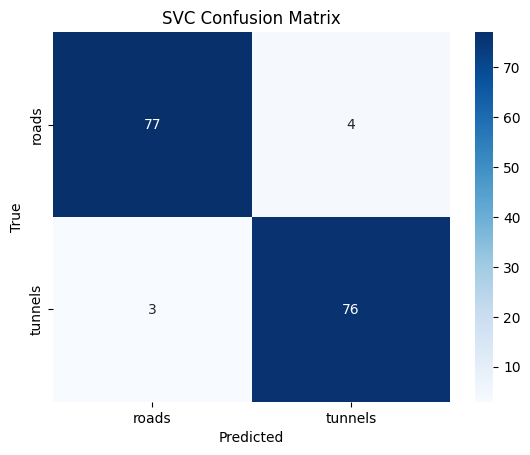

In [35]:
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('SVC' + ' Confusion Matrix')
plt.show()

### K-Nearest Neighbors (KNN) Classifier and Performance Evaluation

In this code snippet, a K-Nearest Neighbors (KNN) classifier is trained on the reduced-dimensional data using the `fit` method. The trained classifier is then used to make predictions on the test data using the `predict` method.

- A KNN classifier is initialized with the number of neighbors set to 3, and the classifier is stored in the variable `knn`.

- The KNN classifier is trained on the reduced-dimensional training data (`X_train`) and corresponding target labels (`y_train`) using the `fit` method. The `fit` method returns the classifier itself.

- The KNN classifier is used to make predictions on the reduced-dimensional test data (`X_test`). The predicted labels are stored in the variable `y_test_pred`.

- The accuracy of the KNN classifier on the training data is computed using the `score` method, which returns the mean accuracy on the given data. This accuracy value is then rounded and stored in the variable `acc_knn`.

- The performance of the KNN classifier on the test data is evaluated using the `class_report` function. This function takes the predicted labels (`y_test_pred`), true labels (`y_test`), and a dataset identifier ('Test') as inputs. It computes and returns the confusion matrix and accuracy of the predictions. These values are stored in the variables `confusion_mat` and `accuracy`, respectively.

The KNN classifier is trained on the reduced-dimensional data and used to make predictions on the test data. The accuracy score provides an evaluation of the classifier's performance on the training data, while the confusion matrix and accuracy metrics give insights into its effectiveness in classifying the audio samples on the test data.


In [47]:
knn = KNeighborsClassifier(n_neighbors = 3)
y_train_pred = knn.fit(X_train, y_train)
y_test_pred = knn.predict(X_test)
acc_knn = round(knn.score(X_train, y_train) * 100, 2)
confusion_mat, accuracy = class_report(y_test_pred, y_test, dataset='Test')

Test Set:

Test Confusion Matrix:
[[80 47]
 [ 0 33]]
Test Classification report:
              precision    recall  f1-score   support

         0.0       1.00      0.63      0.77       127
         1.0       0.41      1.00      0.58        33

    accuracy                           0.71       160
   macro avg       0.71      0.81      0.68       160
weighted avg       0.88      0.71      0.73       160

Test Accuracy: 0.70625




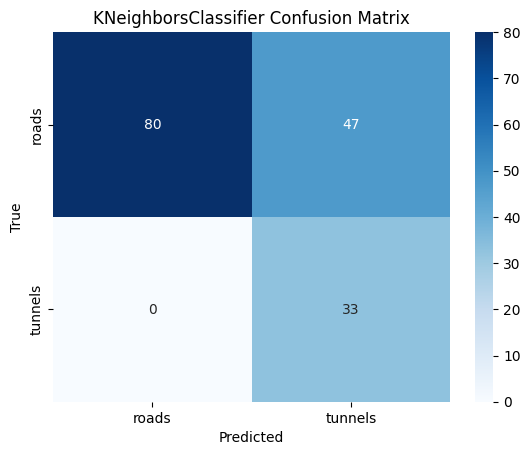

In [37]:
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('KNeighborsClassifier' + ' Confusion Matrix')
plt.show()

### Gaussian Naive Bayes Classifier and Performance Evaluation

In this code snippet, a Gaussian Naive Bayes classifier is trained on the reduced-dimensional data using the `fit` method. The trained classifier is then used to make predictions on the test data using the `predict` method.

- A Gaussian Naive Bayes classifier is initialized and stored in the variable `gaussian`.

- The Gaussian Naive Bayes classifier is trained on the reduced-dimensional training data (`X_train`) and corresponding target labels (`y_train`) using the `fit` method.

- The Gaussian Naive Bayes classifier is used to make predictions on the reduced-dimensional test data (`X_test`). The predicted labels are stored in the variable `y_test_pred`.

- The accuracy of the Gaussian Naive Bayes classifier on the training data is computed using the `score` method, which returns the mean accuracy on the given data. This accuracy value is then rounded and stored in the variable `acc_gaussian`.

- The performance of the Gaussian Naive Bayes classifier on the test data is evaluated using the `class_report` function. This function takes the predicted labels (`y_test_pred`), true labels (`y_test`), and a dataset identifier ('Test') as inputs. It computes and returns the confusion matrix and accuracy of the predictions. These values are stored in the variables `confusion_mat` and `accuracy`, respectively.

The Gaussian Naive Bayes classifier is trained on the reduced-dimensional data and used to make predictions on the test data. The accuracy score provides an evaluation of the classifier's performance on the training data, while the confusion matrix and accuracy metrics give insights into its effectiveness in classifying the audio samples on the test data.


In [46]:
gaussian = GaussianNB()
gaussian.fit(X_train, y_train)
y_test_pred = gaussian.predict(X_test)
acc_gaussian = round(gaussian.score(X_train, y_train) * 100, 2)
confusion_mat, accuracy = class_report(y_test_pred, y_test, dataset='Test')

Test Set:

Test Confusion Matrix:
[[77 20]
 [ 3 60]]
Test Classification report:
              precision    recall  f1-score   support

         0.0       0.96      0.79      0.87        97
         1.0       0.75      0.95      0.84        63

    accuracy                           0.86       160
   macro avg       0.86      0.87      0.85       160
weighted avg       0.88      0.86      0.86       160

Test Accuracy: 0.85625




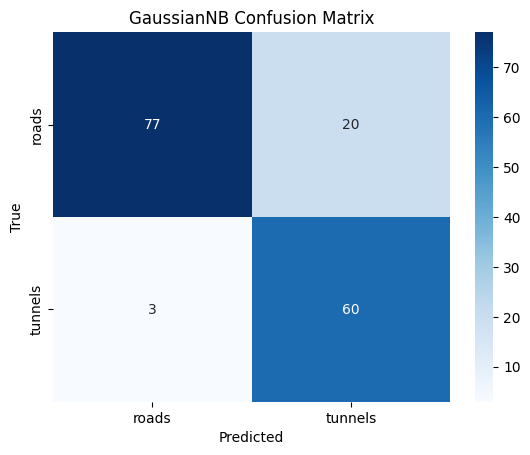

In [39]:
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('GaussianNB' + ' Confusion Matrix')
plt.show()


###  Random Forest Classifier and Performance Evaluation

In this code snippet, a Random Forest classifier is trained on the reduced-dimensional data using the `fit` method. The trained classifier is then used to make predictions on the test data using the `predict` method.

- A Random Forest classifier is initialized with 50 estimators and stored in the variable `random_forest`.

- The Random Forest classifier is trained on the reduced-dimensional training data (`X_train`) and corresponding target labels (`y_train`) using the `fit` method.

- The Random Forest classifier is used to make predictions on the reduced-dimensional test data (`X_test`). The predicted labels are stored in the variable `y_test_pred`.

- The accuracy of the Random Forest classifier on the training data is computed using the `score` method, which returns the mean accuracy on the given data. This accuracy value is then rounded and stored in the variable `acc_random_forest`.

- The performance of the Random Forest classifier on the test data is evaluated using the `class_report` function. This function takes the predicted labels (`y_test_pred`), true labels (`y_test`), and a dataset identifier ('Test') as inputs. It computes and returns the confusion matrix and accuracy of the predictions. These values are stored in the variables `confusion_mat` and `accuracy`, respectively.

The Random Forest classifier is trained on the reduced-dimensional data and used to make predictions on the test data. The accuracy score provides an evaluation of the classifier's performance on the training data, while the confusion matrix and accuracy metrics give insights into its effectiveness in classifying the audio samples on the test data.


In [45]:
random_forest = RandomForestClassifier(n_estimators=50)
random_forest.fit(X_train, y_train)
y_test_pred = random_forest.predict(X_test)
random_forest.score(X_train, y_train)
acc_random_forest = round(random_forest.score(X_train, y_train) * 100, 2)
onfusion_mat, accuracy = class_report(y_test_pred, y_test, dataset='Test')

Test Set:

Test Confusion Matrix:
[[78 23]
 [ 2 57]]
Test Classification report:
              precision    recall  f1-score   support

         0.0       0.97      0.77      0.86       101
         1.0       0.71      0.97      0.82        59

    accuracy                           0.84       160
   macro avg       0.84      0.87      0.84       160
weighted avg       0.88      0.84      0.85       160

Test Accuracy: 0.84375




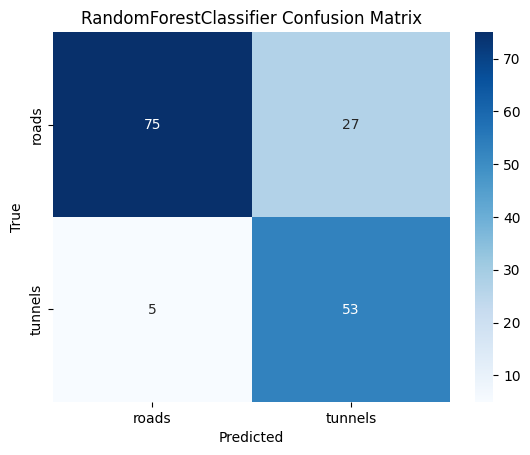

In [41]:
sns.heatmap(confusion_mat, annot=True, cmap='Blues', fmt='d', xticklabels=labels, yticklabels=labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('RandomForestClassifier' + ' Confusion Matrix')
plt.show()
